### RNN - Timeseries forecasting

Build a Recurrent Neural network for the Jena temperature-forecasting problem. In the data you have access to a timeseries of data points coming from sensors installed on
the roof of a building, such as temperature, air pressure, and humidity, which you can use
to predict what the temperature will be 24 hours after the last data point

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, GRU, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.optimizers import RMSprop

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


The dataset covers observations recorded between 2009-2016. There are 14 features which were recorded every 10 minutes.

In [0]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/data/'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.replace('"','').split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
420551


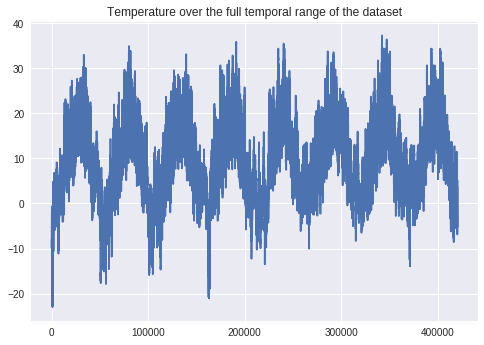

In [0]:
#Parse the data into a numpy array

float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values
  

#Plot the temperature timeseries
temp = float_data[:,1] 
plt.plot(range(len(temp)),temp)
plt.title("Temperature over the full temporal range of the dataset")
plt.show()

We can clearly see the yearly periodicity of temperature

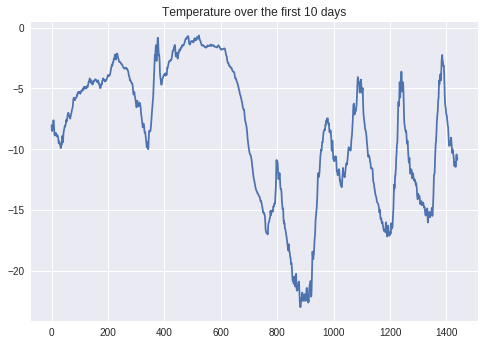

In [0]:
#Plot the first 10 days of temperature timeseries
plt.plot(range(1440),temp[:1440])
plt.title("Temperature over the first 10 days")
plt.show()

We can observe the daily periodicity, especially evident for the last 4 days. Also
note that this 10-day period must be coming from a fairly cold winter month.

### Preparing the data

We can formulate the problem as - given data going as far back
as *lookback* timestepsand sampled every *steps* timesteps,
can you predict the temperature in *delay* timesteps

- lookback = 720       —Observations will go back 5 days.
- steps = 6                  —Observations will be sampled at one data point per hour.
- delay = 144              —Targets will be 24 hours in the future.

For data preprocessing we normalize the data and also write a python generator to generate training sample batches. We take the firset 200k timesteps as training data.

In [0]:
#normalize the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
#Generator yielding timeseries samples and their targets

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  
  while 1:
    if shuffle:
      rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
      
    samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
    
    targets = np.zeros((len(rows),))
    
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
      
    yield samples, targets

Prepare the training, validation and test sets using the generator function

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, 
                      max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, 
                      max_index=300000, step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, 
                      max_index=None, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size  #number of steps to draw from val_gen 
test_steps = (len(float_data) - 300001 - lookback) // batch_size #number of steps to draw from test_gen

### Determine baseline performance

What does performance look like if we simply predict that the temperature 24 hours from now will be equal to the temperature right now?

In [0]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:,-1,1]
    mae = np.mean(np.abs(preds-targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2897359729905486


In [0]:
#Convert mae to celsius by multiplying it with the temperature_std
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


This yields an MAE of 0.29 which translates to 2.57 C which is a large average absolute error.

Next, lets try a small densely connected networks to evaluate its performance before we train computationally expensive models such as RNNs.

In [0]:
def plot_loss(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(1,len(loss)+1)

  plt.plot(epochs, loss,'bo',label='Training loss')
  plt.plot(epochs, val_loss,'b',label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [0]:
model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/simpleNN_temp_model.h5')

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 1.5196 - val_loss: 0.8526
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.5764 - val_loss: 0.4566
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.3212 - val_loss: 0.3020
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2730 - val_loss: 0.2962
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2580 - val_loss: 0.3444
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2464 - val_loss: 0.3192
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2384 - val_loss: 0.3122
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2344 - val_loss: 0.3102
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2289 - val_loss: 0.3107
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.226

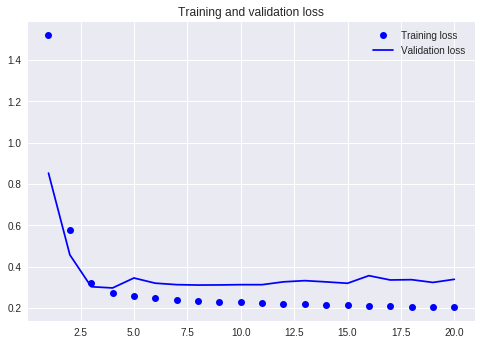

In [0]:
plot_loss(history)

Some of the validation losses are close to the no-learning baseline. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. As for the Neural network, by flattening the timeseries we removed the notion of time from the input data. 

Let's try a Recurrent neural network using GRU layers that can fit the sequence data because it can learn from the temporal ordering of data points.

### RNN using GRU layers

In [0]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/GRU_temp_model.h5')

Epoch 1/20
500/500 [==============================] - 192s 384ms/step - loss: 0.3244 - val_loss: 0.2844
Epoch 2/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2878 - val_loss: 0.2734
Epoch 3/20
500/500 [==============================] - 192s 384ms/step - loss: 0.2794 - val_loss: 0.2678
Epoch 4/20
500/500 [==============================] - 192s 385ms/step - loss: 0.2772 - val_loss: 0.2664
Epoch 5/20
500/500 [==============================] - 192s 384ms/step - loss: 0.2715 - val_loss: 0.2626
Epoch 6/20
500/500 [==============================] - 192s 385ms/step - loss: 0.2681 - val_loss: 0.2630
Epoch 7/20
500/500 [==============================] - 192s 384ms/step - loss: 0.2623 - val_loss: 0.2685
Epoch 8/20
500/500 [==============================] - 193s 386ms/step - loss: 0.2578 - val_loss: 0.2671
Epoch 9/20
500/500 [==============================] - 193s 386ms/step - loss: 0.2537 - val_loss: 0.2726
Epoch 10/20
500/500 [==============================] - 192s 385m

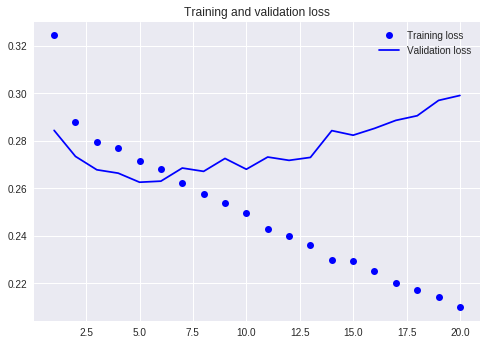

In [0]:
plot_loss(history)

The new validation MAE of ~0.262 translates to a mean absolute error of 2.35 C after denormalization, which is better than our initial error of 2.57 C. We can improve this further by using recurrent dropout to fight overfitting.

Note - Networks being regularized tke longer to converge so we double the number of epochs

In [0]:
model = Sequential()
model.add(GRU(32, input_shape=(None,float_data.shape[-1]), 
              dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, epochs=40,
                             steps_per_epoch=500,
                             validation_data=val_gen,
                              validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/GRU_recurrentDropout_temp_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 237s 474ms/step - loss: 0.3403 - val_loss: 0.2763
Epoch 2/40
500/500 [==============================] - 232s 464ms/step - loss: 0.3154 - val_loss: 0.2743
Epoch 3/40
500/500 [==============================] - 232s 464ms/step - loss: 0.3079 - val_loss: 0.2737
Epoch 4/40
500/500 [==============================] - 233s 465ms/step - loss: 0.3053 - val_loss: 0.2688
Epoch 5/40
500/500 [==============================] - 234s 469ms/step - loss: 0.3008 - val_loss: 0.2716
Epoch 6/40
500/500 [==============================] - 235s 470ms/step - loss: 0.2986 - val_loss: 0.2687
Epoch 7/40
500/500 [==============================] - 234s 468ms/step - loss: 0.2973 - val_loss: 0.2715
Epoch 8/40
500/500 [=================

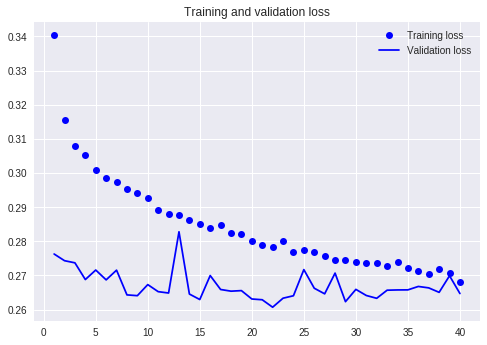

In [0]:
plot_loss(history)

We have stable validation loss scores and are not overfitting anymore. To improve performance lets increase the capacity of the network by stacking recurrent layers

In [0]:
model = Sequential()
model.add(GRU(32, input_shape=(None,float_data.shape[-1]),
              return_sequences=True,
              dropout=0.1, recurrent_dropout=0.5))
model.add(GRU(64, activation='relu',
             dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, epochs=40,
                             steps_per_epoch=500,
                             validation_data=val_gen,
                              validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/StackedGRU_recurrentDropout_temp_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 445s 890ms/step - loss: 0.3355 - val_loss: 0.2867
Epoch 2/40
500/500 [==============================] - 443s 887ms/step - loss: 0.3133 - val_loss: 0.2721
Epoch 3/40
500/500 [==============================] - 440s 879ms/step - loss: 0.3075 - val_loss: 0.2737
Epoch 4/40
500/500 [==============================] - 438s 877ms/step - loss: 0.2999 - val_loss: 0.2734
Epoch 5/40
500/500 [==============================] - 439s 878ms/step - loss: 0.2986 - val_loss: 0.2724
Epoch 6/40
500/500 [==============================] - 437s 874ms/step - loss: 0.2951 - val_loss: 0.2704
Epoch 7/40
500/500 [==============================] - 438s 876ms/step - loss: 0.2903 - val_loss: 0.2691
Epoch 8/40
500/500 [=================

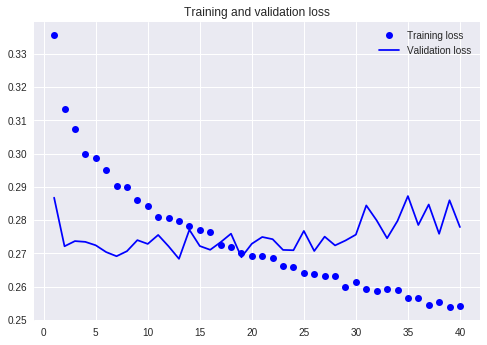

In [0]:
plot_loss(history)

The results improved a bit but not significantly. Maybe we need to increase the size of the layers. That would require additional computation, which may not be worth it since adding a layer didn't help significantly. Further steps -

- Adjust the number of units in each recurrent layer in the stacked setup. 
- Adjust the learning rate used by the RMSprop optimizer.
- Try LSTM layers instead of GRU layers.
- Try using a bigger densely connected regressor on top of the recurrent layers, that is, a bigger Dense layer or even a stack of Dense layers.


### 1D Convolutional Neural network

Let's evaluate 1D CNNs performance, and also build a model where the 1D CNN is a  preprocessing step berfore an RNN, thus combining the speed and lightness of CNNs with order sensitivity of RNNs

In [0]:
#simple 1D convnet

model = Sequential()
model.add(Conv1D(32, 5, activation='relu',
                input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/Conv1D_temp_model.h5')

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4147 - val_loss: 0.4415
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3637 - val_loss: 0.4475
Epoch 3/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3410 - val_loss: 0.4900
Epoch 4/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3237 - val_loss: 0.4804
Epoch 5/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3138 - val_loss: 0.4534
Epoch 6/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3016 - val_loss: 0.4678
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2905 - val_loss: 0.4715
Epoch 8/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2853 - val_loss: 0.4679
Epoch 9/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2793 - val_loss: 0.4947
Epoc

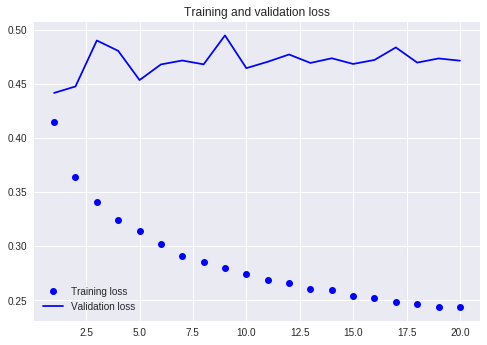

In [0]:
plot_loss(history)

The validation MAE doesnt even beat the common sense baseline, so the 1D CNN is inadequate by itself. This happens because the CNN looks for patterns anywhere in the input timeseries, thus lacking order sensitivity beyond a local scale of its convolution windows.


### Combining 1D CNN and RNN

By using the 1D ConvNet as a preprocessing step for an RNN, we get the advantage of speed while retaining order-sensitivity.

In [0]:
step = 3  #previously 6 (1 point per hour, now 1 point per 30 min)
lookback = 1440
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, 
                      max_index=200000, shuffle=True, step=step)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, 
                      max_index=300000, step=step)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, 
                      max_index=None, step=step)

val_steps = (300000 - 200001 - lookback) // batch_size  #number of steps to draw from val_gen 
test_steps = (len(float_data) - 300001 - lookback) // batch_size #number of steps to draw from test_gen

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu',
                       input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

model.save('gdrive/My Drive/Colab Notebooks/models/Conv1D_GRU_temp_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 175s 351ms/step - loss: 0.3366 - val_loss: 0.2877
Epoch 2/20
500/500 [==============

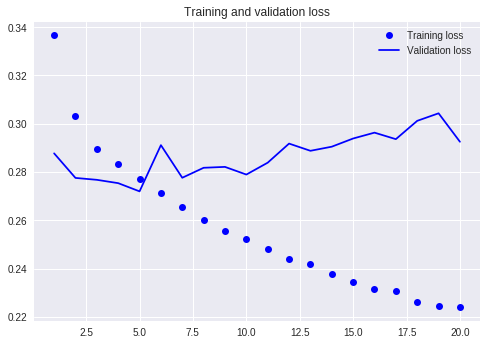

In [0]:
plot_loss(history)

The validation loss isn't as good as the regularized GRU, but its faster to train even though it looks at twice as much data.